# Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from exercise_code.VAE import VAE
from exercise_code.sampling import Sampling

from matplotlib.patches import Rectangle

# Plot the datasets

This shows a scatter plot of the train and test set including the sensitive area with the corner positions (130,70) and (150/50)

In [2]:
# Parameters of the rectangle representing the critical zone 
REC_X_POS = 130
REC_Y_POS = 50
REC_WIDTH = 150 - 130
REC_HEIGHT = 70 - 50

def plot_rectangle():
    rectangle = Rectangle((REC_X_POS, REC_Y_POS), REC_WIDTH, REC_HEIGHT, edgecolor='orange', facecolor='none')
    plt.gca().add_patch(rectangle)

In [3]:
# Load the datasets
train_set = np.load('../../FireEvac_train_set.npy')
test_set = np.load('../../FireEvac_test_set.npy')

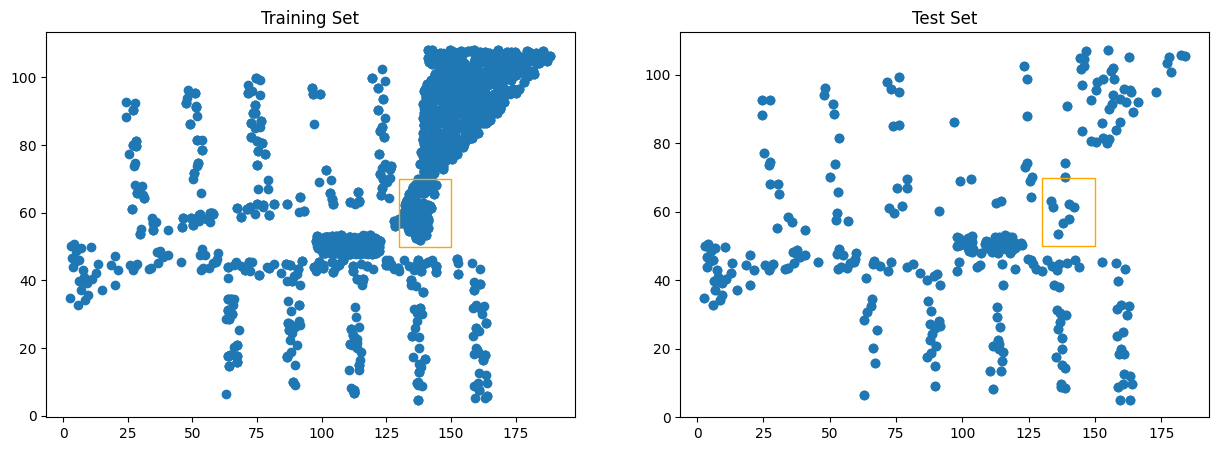

In [4]:
# Create a new figure
plt.figure(figsize=(15, 5))

# Plot the train set
plt.subplot(1, 2, 1)  # 1 row, 2 columns, index 1
plt.scatter(train_set[:,0], train_set[:,1])
plot_rectangle()
plt.title("Training Set")

# Plot the test set
plt.subplot(1, 2, 2)  # 1 row, 2 columns, index 2
plt.scatter(test_set[:,0], test_set[:,1])
plot_rectangle()
plt.title("Test Set")

# Show the figure with both subplots
plt.show()

# Plot the normalized datasets

This shows a scatter plot of the train and test set including the sensitive area in the normalized space

In [5]:
# Normalize train_set
train_set_normal = train_set.copy()  # Create a copy to avoid modifying original data
train_set_normal[:,0] = train_set[:,0] / np.max(train_set[:,0])  # Normalize x values
train_set_normal[:,1] = train_set[:,1] / np.max(train_set[:,1])  # Normalize y values

# Normalize test_set
test_set_normal = test_set.copy()  # Create a copy to avoid modifying original data
test_set_normal[:,0] = test_set[:,0] / np.max(test_set[:,0])  # Normalize x values
test_set_normal[:,1] = test_set[:,1] / np.max(test_set[:,1])  # Normalize y values

In [6]:
# Maximum x and y values from the train_set
x_max = np.max(train_set[:,0])
y_max = np.max(train_set[:,1])

print(f"x_max = {x_max} and y_max = {y_max}")

# Normalize rectangle parameters
REC_X_POS_NORM = REC_X_POS / x_max
REC_Y_POS_NORM = REC_Y_POS / y_max
REC_WIDTH_NORM = REC_WIDTH / x_max
REC_HEIGHT_NORM = REC_HEIGHT / y_max

    
def plot_normalized_rectangle():
    rectangle = Rectangle((REC_X_POS_NORM, REC_Y_POS_NORM), REC_WIDTH_NORM, REC_HEIGHT_NORM, edgecolor='orange', facecolor='none')
    plt.gca().add_patch(rectangle)

x_max = 188.49331237472774 and y_max = 108.17577426393086


In [7]:
# Normalize rectangle parameters using hardcoded numbers of the guessed grid size
GRID_WIDTH = 200
GRID_HEIGHT = 110

REC_X_POS_GRID_NORM = REC_X_POS / GRID_WIDTH
REC_Y_POS_GRID_NORM = REC_Y_POS / GRID_HEIGHT
REC_WIDTH_GRID_NORM = REC_WIDTH / GRID_WIDTH
REC_HEIGHT_GRID_NORM = REC_HEIGHT / GRID_HEIGHT   

    
def plot_grid_rectangle():
    rectangle = Rectangle((REC_X_POS_GRID_NORM, REC_Y_POS_GRID_NORM), REC_WIDTH_GRID_NORM, REC_HEIGHT_GRID_NORM, edgecolor='black', facecolor='none')
    plt.gca().add_patch(rectangle)

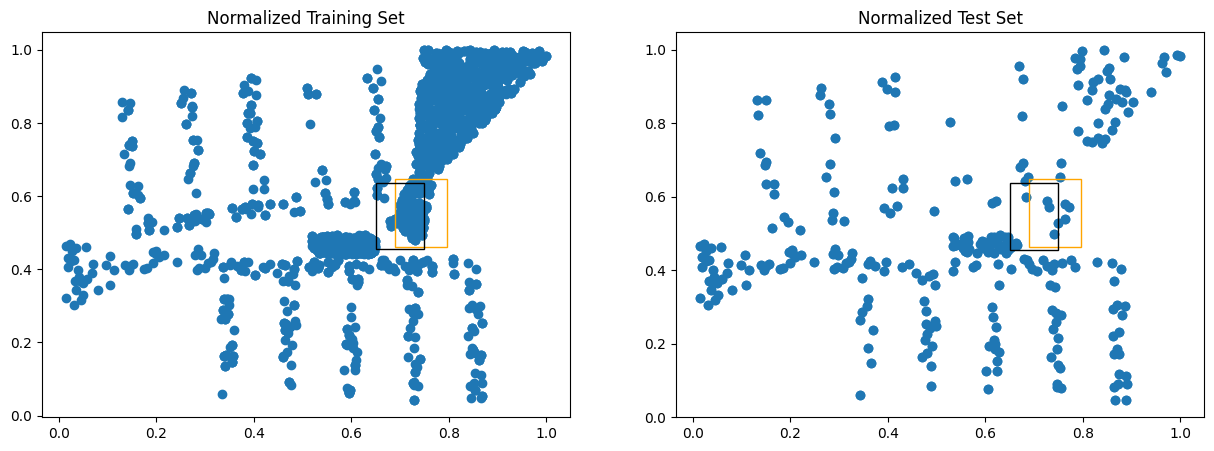

In [8]:
# Create a new figure
plt.figure(figsize=(15, 5))

# Plot the train set
plt.subplot(1, 2, 1)  # 1 row, 2 columns, index 1
plt.scatter(train_set_normal[:,0], train_set_normal[:,1])
plot_normalized_rectangle()
plot_grid_rectangle()
plt.title("Normalized Training Set")

# Plot the test set
plt.subplot(1, 2, 2)  # 1 row, 2 columns, index 2
plt.scatter(test_set_normal[:,0], test_set_normal[:,1])
plot_normalized_rectangle()
plot_grid_rectangle()
plt.title("Normalized Test Set")

# Show the figure with both subplots
plt.show()

# Create the VAE

In [9]:
parameters = {
    "input_shape": (2, ),
    "output_shape": (2, ),
    "hidden_layer_size": 64,
    "latent_dim": 2,
    "adam_learning_rate": 0.005,
    "batch_size": 64,
    "epochs": 50
}

## Encoder

In [69]:
# Encoder network
encoder_inputs = keras.Input(parameters["input_shape"])
X = layers.Flatten(name="Flatten")(encoder_inputs) 
x = layers.Dense(parameters["hidden_layer_size"], activation="relu")(X)
x = layers.Dense(parameters["hidden_layer_size"], activation="relu")(x)
z_mean = layers.Dense(parameters["latent_dim"], name="z_mean")(x)
z_log_var = layers.Dense(parameters["latent_dim"], name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 Flatten (Flatten)              (None, 2)            0           ['input_9[0][0]']                
                                                                                                  
 dense_20 (Dense)               (None, 64)           192         ['Flatten[0][0]']                
                                                                                                  
 dense_21 (Dense)               (None, 64)           4160        ['dense_20[0][0]']               
                                                                                            

## Decoder

In [70]:
# Decoder network
latent_inputs = keras.Input(shape=(parameters["latent_dim"],))
x = layers.Dense(parameters["hidden_layer_size"], activation="relu")(latent_inputs)
x = layers.Dense(parameters["hidden_layer_size"], activation="relu")(x)
decoder_outputs = layers.Dense(2, activation="linear")(x)
decoder_outputs = layers.Reshape(parameters["output_shape"], name="Reshape")(decoder_outputs)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary() 

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_22 (Dense)            (None, 64)                192       
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 dense_24 (Dense)            (None, 2)                 130       
                                                                 
 Reshape (Reshape)           (None, 2)                 0         
                                                                 
Total params: 4,482
Trainable params: 4,482
Non-trainable params: 0
_________________________________________________________________


## Compile and train the VAE

In [13]:
vae = VAE(encoder, decoder, scale=2*1)

# Compile and train the model
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=parameters["adam_learning_rate"]))
vae.fit(train_set_normal, epochs=parameters["epochs"], batch_size=parameters["batch_size"])

Epoch 1/50
47/47 [==============================] - 1s 1ms/step - loss: 1.2454 - reconstruction_loss: 1.2410 - kl_loss: 3.5947e-04
Epoch 2/50
47/47 [==============================] - 0s 1ms/step - loss: 1.2383 - reconstruction_loss: 1.2383 - kl_loss: 1.9285e-04
Epoch 3/50
47/47 [==============================] - 0s 1ms/step - loss: 1.2401 - reconstruction_loss: 1.2350 - kl_loss: 1.4156e-04
Epoch 4/50
47/47 [==============================] - 0s 1ms/step - loss: 1.2408 - reconstruction_loss: 1.2372 - kl_loss: 1.4621e-04
Epoch 5/50
47/47 [==============================] - 0s 1ms/step - loss: 1.2388 - reconstruction_loss: 1.2366 - kl_loss: 3.1405e-04
Epoch 6/50
47/47 [==============================] - 0s 1ms/step - loss: 1.2334 - reconstruction_loss: 1.2345 - kl_loss: 3.0304e-04
Epoch 7/50
47/47 [==============================] - 0s 1ms/step - loss: 1.2337 - reconstruction_loss: 1.2345 - kl_loss: 1.8000e-04
Epoch 8/50
47/47 [==============================] - 0s 1ms/step - loss: 1.2390 - re

# Reconstruction of the test set

In [14]:
def plot_reconstructed_test_set(vae, data):
    z_mean, z_log_var, z = vae.encoder(data)
    reconstructed_test_set = vae.decoder(z).numpy()
    
    flattened_test_set = data.reshape(-1, 2)
    plt.scatter(flattened_test_set[:, 0], flattened_test_set[:, 1], label='Dataset')
    
    flattened_reconstructed_set = reconstructed_test_set.reshape(-1, 2)
    plt.scatter(flattened_reconstructed_set[:, 0], flattened_reconstructed_set[:, 1], color='red', alpha=0.5, label='Reconstructed')
    
    # Compute the average position and plot it
    average_position = np.mean(flattened_test_set, axis=0)
    plt.scatter(average_position[0], average_position[1], color='green', marker='X', s=200, label='Average position')
 
    
    plot_normalized_rectangle()
    plt.legend()

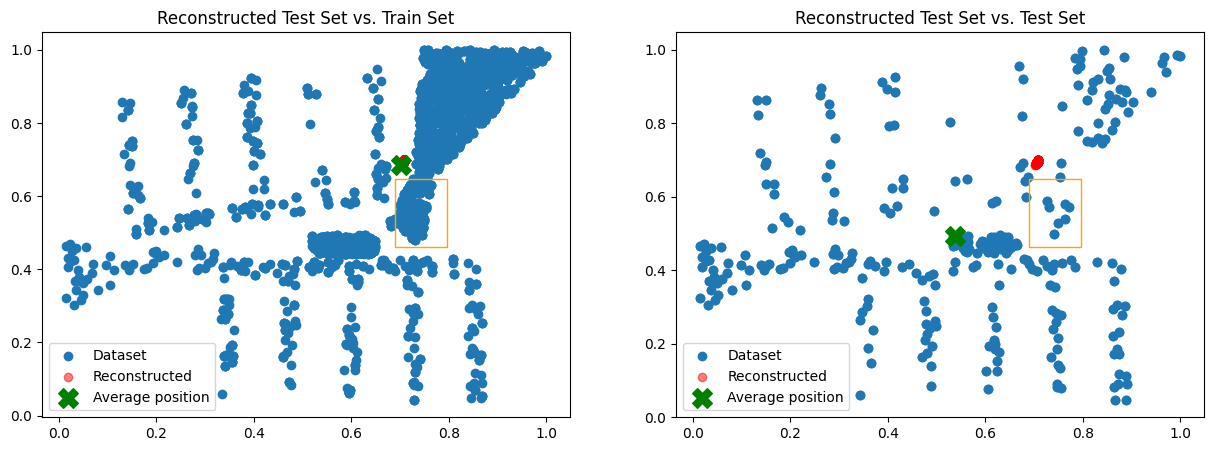

Average position: [0.70178963 0.68561783]


In [15]:
# Create a new figure
plt.figure(figsize=(15, 5))

# Plot reconstructed test values vs. the train set
plt.subplot(1, 2, 1)  # 1 row, 2 columns, index 1
plot_reconstructed_test_set(vae, train_set_normal)
plt.title('Reconstructed Test Set vs. Train Set')

# Plot reconstructed test values vs. the test set
plt.subplot(1, 2, 2)  # 1 row, 2 columns, index 2
plot_reconstructed_test_set(vae, test_set_normal)
plt.title('Reconstructed Test Set vs. Test Set')

plt.show()

average_position = np.mean(train_set_normal, axis=0)
print("Average position:", average_position)

# Generate 1000 Samples

In [16]:
NUM_OF_SAMPLES = 1000

In [17]:
def plot_generated_samples(vae, latent_dim, data):
    # Generate random samples from the latent space
    z = np.random.normal(size=(NUM_OF_SAMPLES, vae.encoder.get_layer("z_mean").output_shape[-1]))
    generated_samples = vae.decoder(z).numpy()
  
    flattened_test_set = data.reshape(-1, 2)
    plt.scatter(flattened_test_set[:, 0], flattened_test_set[:, 1], label='Dataset')
    
    flattened_generated_samples = generated_samples.reshape(-1, 2)
    plt.scatter(flattened_generated_samples[:, 0], flattened_generated_samples[:, 1], color='green', alpha=0.5, label='Generated')
    
    plot_normalized_rectangle()
    plt.legend() 

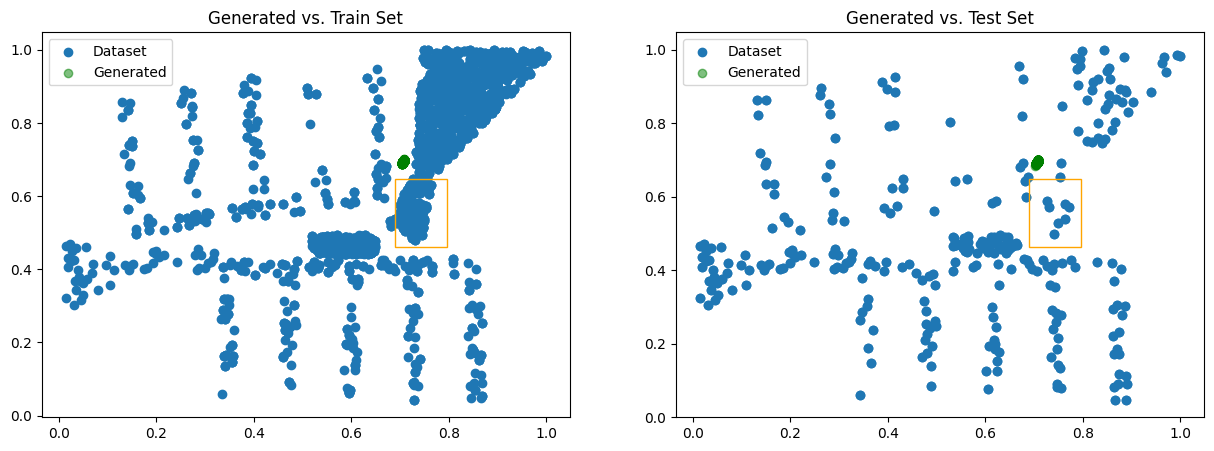

In [18]:
# Create a new figure
plt.figure(figsize=(15, 5))

# Plot generated values vs. the train set
plt.subplot(1, 2, 1)  # 1 row, 2 columns, index 1
plot_generated_samples(vae, parameters['latent_dim'], train_set_normal)
plt.title('Generated vs. Train Set')

# Plot generated values vs. the test set
plt.subplot(1, 2, 2)  # 1 row, 2 columns, index 2
plot_generated_samples(vae, parameters['latent_dim'], test_set_normal)
plt.title('Generated vs. Test Set')

plt.show()

# How many samples (people) are approximately needed to exceed the critical number at the main entrance?

In [19]:
def is_inside_sensitive_area(position, sensitive_area):
    x, y = position
    x1, y1 = sensitive_area[0]
    x2, y2 = sensitive_area[1]

    return (x >= x1 and x <= x2 and y >= y2 and y <= y1)

In [20]:
sensitive_area = np.array([[130.0, 70.0], [150.0, 50.0]])
sensitive_area[:, 0] /= x_max
sensitive_area[:, 1] /= y_max

print(sensitive_area)

[[0.68967964 0.64709498]
 [0.7957842  0.4622107 ]]


Count = 0 / 6000


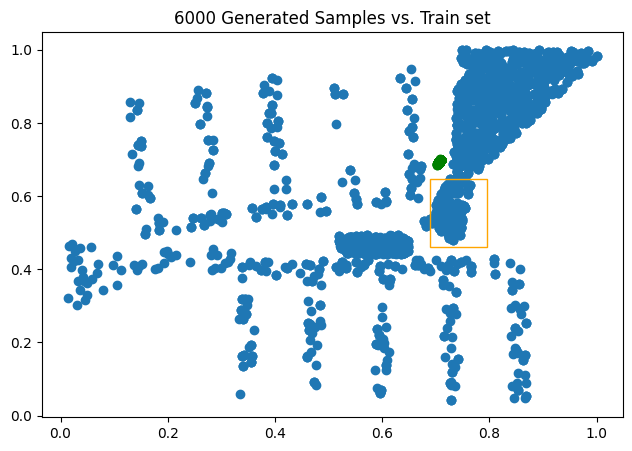

In [21]:
NUM_GENRATED_SAMPLES = 6000

z = np.random.normal(size=(6000, vae.encoder.get_layer("z_mean").output_shape[-1]))
generated_samples = vae.decoder(z).numpy().reshape(-1, 2).flatten()
flattened_generated_samples = generated_samples.reshape(-1, 2)

# Count how many of the sampled points are inside the sensitive area
# Note: Actually this should have been a while loop that breaks once the threshhold of 100 people inside the sensitive area was reached. Unfortunately we never hit that rectangle, meaning that while loop would never end.
# That is why took a for loop approach with an high enough loop count.
count = 0
for sample in flattened_generated_samples:
    if is_inside_sensitive_area(sample, sensitive_area):
        count += 1
print(f"Count = {count} / {NUM_GENRATED_SAMPLES}")

# Create scatter plot
plt.figure(figsize=(7.5, 5))
plt.scatter(flattened_generated_samples[:, 0], flattened_generated_samples[:, 1], color='green', alpha=0.5, label='Generated')

flattened_test_set = train_set_normal.reshape(-1, 2)
plt.scatter(flattened_test_set[:, 0], flattened_test_set[:, 1], label='Dataset')

plot_normalized_rectangle()
plt.title(f'{NUM_GENRATED_SAMPLES} Generated Samples vs. Train set');

# Plot the normalized datasets in [-1, 1] range

This shows a scatter plot of the train and test set including the sensitive area in the normalized space

In [22]:
# Normalize train_set
train_set_normal = train_set.copy()  # Create a copy to avoid modifying original data
train_set_normal[:,0] = train_set[:,0] / np.max(train_set[:,0]) * 2 - 1  # Normalize x values
train_set_normal[:,1] = train_set[:,1] / np.max(train_set[:,1]) * 2 - 1 # Normalize y values

# Normalize test_set
test_set_normal = test_set.copy()  # Create a copy to avoid modifying original data
test_set_normal[:,0] = test_set[:,0] / np.max(test_set[:,0]) * 2 - 1 # Normalize x values
test_set_normal[:,1] = test_set[:,1] / np.max(test_set[:,1]) * 2 - 1 # Normalize y values

In [23]:
# Maximum x and y values from the train_set
x_max = np.max(train_set[:,0])
y_max = np.max(train_set[:,1])

print(f"x_max = {x_max} and y_max = {y_max}")

# Normalize rectangle parameters
REC_X_POS_NORM = REC_X_POS / x_max  * 2 - 1
REC_Y_POS_NORM = REC_Y_POS / y_max  * 2 - 1
REC_WIDTH_NORM = (REC_X_POS + REC_WIDTH) / x_max * 2 - 1 - (REC_X_POS / x_max * 2 - 1)
print(REC_WIDTH_NORM)
REC_HEIGHT_NORM = (REC_Y_POS + REC_HEIGHT) / y_max * 2 - 1 - (REC_Y_POS / y_max * 2 - 1)
print(REC_HEIGHT_NORM)

x_max = 188.49331237472774 and y_max = 108.17577426393086
0.21220912029217964
0.3697685574443559


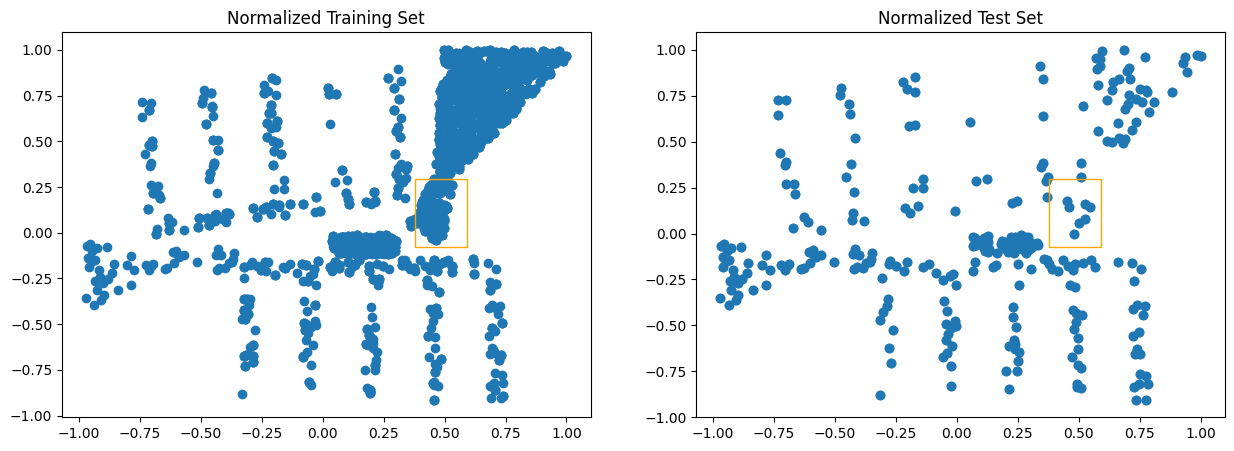

In [52]:
# Create a new figure
plt.figure(figsize=(15, 5))

# Plot the train set
plt.subplot(1, 2, 1)  # 1 row, 2 columns, index 1
plt.scatter(train_set_normal[:,0], train_set_normal[:,1])
plot_normalized_rectangle()
plt.title("Normalized Training Set")

# Plot the test set
plt.subplot(1, 2, 2)  # 1 row, 2 columns, index 2
plt.scatter(test_set_normal[:,0], test_set_normal[:,1])
plot_normalized_rectangle()
plt.title("Normalized Test Set")

# Show the figure with both subplots
plt.show()

In [25]:
vae = VAE(encoder, decoder, scale=2*1)

# Compile and train the model
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=parameters["adam_learning_rate"]))
vae.fit(train_set_normal, epochs=parameters["epochs"], batch_size=parameters["batch_size"])

Epoch 1/50
47/47 [==============================] - 1s 1ms/step - loss: 1.4431 - reconstruction_loss: 1.3720 - kl_loss: 0.0017
Epoch 2/50
47/47 [==============================] - 0s 1ms/step - loss: 1.3342 - reconstruction_loss: 1.3153 - kl_loss: 0.0138
Epoch 3/50
47/47 [==============================] - 0s 1ms/step - loss: 1.2610 - reconstruction_loss: 0.9042 - kl_loss: 0.2108
Epoch 4/50
47/47 [==============================] - 0s 1ms/step - loss: 0.7690 - reconstruction_loss: 0.5302 - kl_loss: 0.3088
Epoch 5/50
47/47 [==============================] - 0s 1ms/step - loss: 1.0743 - reconstruction_loss: 0.6924 - kl_loss: 0.3285
Epoch 6/50
47/47 [==============================] - 0s 1ms/step - loss: 0.9021 - reconstruction_loss: 0.4461 - kl_loss: 0.4049
Epoch 7/50
47/47 [==============================] - 0s 1ms/step - loss: 0.8738 - reconstruction_loss: 0.3588 - kl_loss: 0.3668
Epoch 8/50
47/47 [==============================] - 0s 1ms/step - loss: 0.6000 - reconstruction_loss: 0.3315 - 

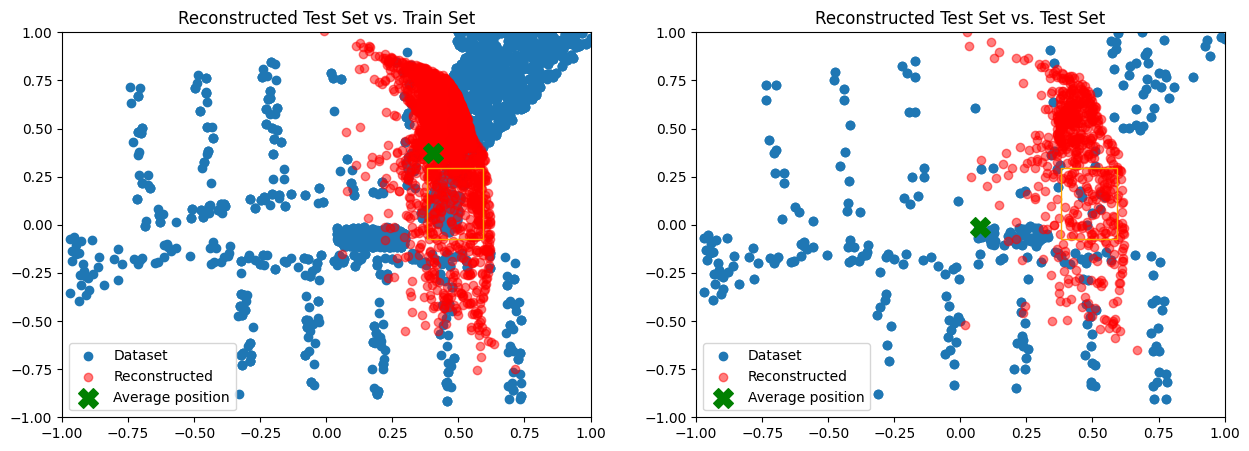

Average position: [0.40357925 0.37123567]


In [26]:
# Create a new figure
plt.figure(figsize=(15, 5))

# Plot reconstructed test values vs. the train set
plt.subplot(1, 2, 1)  # 1 row, 2 columns, index 1
plot_reconstructed_test_set(vae, train_set_normal)
plt.title('Reconstructed Test Set vs. Train Set')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

# Plot reconstructed test values vs. the test set
plt.subplot(1, 2, 2)  # 1 row, 2 columns, index 2
plot_reconstructed_test_set(vae, test_set_normal)
plt.title('Reconstructed Test Set vs. Test Set')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()

average_position = np.mean(train_set_normal, axis=0)
print("Average position:", average_position)

# Random generated points dataset plot

This shows a scatter plot of the train and test set

In [68]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Generate your data, for now let's make 1000 random 2D points
data = np.random.rand(1000, 2)

scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)
data_normalized

array([[0.70732173, 0.74469829],
       [0.02912121, 0.07840836],
       [0.5828418 , 0.31058769],
       ...,
       [0.4692316 , 0.83508588],
       [0.82277523, 0.15720309],
       [0.73183514, 0.41316878]])

In [71]:
vae = VAE(encoder, decoder, scale=2*1)

# Compile and train the model
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=parameters["adam_learning_rate"]))
vae.fit(data_normalized, epochs=parameters["epochs"], batch_size=parameters["batch_size"])

Epoch 1/50
16/16 [==============================] - 1s 2ms/step - loss: 4.3357 - reconstruction_loss: 2.9147 - kl_loss: 0.0390
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 1.8203 - reconstruction_loss: 1.6497 - kl_loss: 0.0512
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 1.5064 - reconstruction_loss: 1.4876 - kl_loss: 0.0091
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 1.4474 - reconstruction_loss: 1.4235 - kl_loss: 0.0047
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 1.4020 - reconstruction_loss: 1.4007 - kl_loss: 0.0029
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 1.3963 - reconstruction_loss: 1.3877 - kl_loss: 0.0021
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 1.3891 - reconstruction_loss: 1.3898 - kl_loss: 0.0017
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 1.3924 - reconstruction_loss: 1.3925 - 

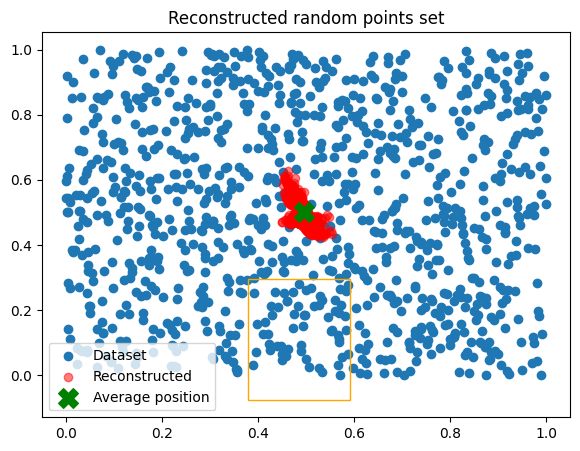

Average position: [0.49617264 0.50057206]


In [73]:
# Create a new figure
plt.figure(figsize=(15, 5))

# Plot reconstructed test values vs. the train set
plt.subplot(1, 2, 1)  # 1 row, 2 columns, index 1
plot_reconstructed_test_set(vae, data_normalized)
plt.title('Reconstructed random points set')

plt.show()

average_position = np.mean(data_normalized, axis=0)
print("Average position:", average_position)